In [64]:
import tensorflow as tf
import xml
import numpy as np
from pylab import *
%matplotlib inline
import xml.etree.ElementTree as ET
import cv2
import os
from matplotlib import patches
from random import shuffle

In [2]:
import sys
reload(sys)  # Reload does the trick!
#sys.setdefaultencoding('UTF8')

NameError: name 'reload' is not defined

In [1]:
import tensorflow
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte

In [11]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [12]:
# Need to implement image resizing!!! (and maybe also various augmentations)
# Bring from 0, 255 to 0, 1
# Subtract mean
# Then, bounding boxes will need re-scaled also..

In [13]:
# Non-batched input
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Softmax
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


In [20]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
sess.run(tf.initialize_all_variables())
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

In [21]:
batch = mnist.train.next_batch(50)

NameError: name 'mnist' is not defined

In [61]:
def crop_resize_image(image, bounding_box, desired_dimension):
    x = bounding_box.xmin
    y = bounding_box.ymin
    width = bounding_box.xmax - bounding_box.xmin
    height = bounding_box.ymax - bounding_box.ymin
    shorter_dimension = min(width, height)
    #if shorter_dimension > desired_dimension:
    cropped_image = image[y:y+shorter_dimension, x:x+shorter_dimension]
    resized_image = cv2.resize(cropped_image, (desired_dimension, desired_dimension))
    return resized_image

In [68]:
def get_batch(filenames, num_images):
    shuffle(filenames)
    images = []
    classes = []
    for filename in filenames[:num_images]:
        bounding_boxes = get_bounding_boxes(filename)
        shuffle(bounding_boxes)
        image = crop_resize_image(read_jpeg(filename), bounding_boxes[0], 64)
        images.append(image)
        classes.append(bounding_boxes[0].class_name)

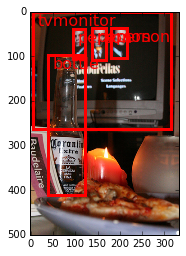

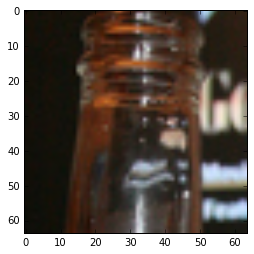

In [63]:
filename = train_filenames[3]
resize = crop_resize_image(read_jpeg(filename), get_bounding_boxes(filename)[1], 64)
show_image(filename, get_bounding_boxes(filename))
show_image(resize)

In [65]:
# PASCAL VOC Data import
# DO NOT EDIT HERE! Modify in its own file
home_dir = os.path.expanduser('~') + "/"
datasets_dir = home_dir + "external_drive/"
voc_2012_dir = datasets_dir + "VOC/VOC2012/VOCdevkit/VOC2012/"

classes = {"aeroplane":1, "bicycle":2, "boat":3, "bottle":4, "bus":5, "car":6, "cat":7,
"chair":8, "cow":9, "dining table":10, "dog":11, "horse":12, "motorbike":13, "person":14,
"potted plant":15, "sheep":16, "train":17, "TV":18, "sofa":19, "bird":20}

class bounding_box:
    def __init__(self, class_name, xmin, xmax, ymin, ymax):
        self.class_name = class_name
        #self.bbox_coords = bbox_coords #xmax, xmin, ymax, ymin
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax

# Get list of training images
train_filenames = []
with open(voc_2012_dir + "ImageSets/Main/train.txt", "r") as file:
    for line in file:
        train_filenames.append(line.strip())
        
# Read an annotation file, return a list of bounding boxes
def get_bounding_boxes(filename):
    bounding_boxes = []
    xmldoc = ET.parse(voc_2012_dir + "Annotations/{}.xml".format(filename))
    objects = xmldoc.findall('object')
    for thing in objects:
        name = thing.find('name').text
        box = thing.find('bndbox')
        xmax = int(box.find('xmax').text)
        xmin = int(box.find('xmin').text)
        ymax = int(box.find('ymax').text)
        ymin = int(box.find('ymin').text)
        bounding_boxes.append(bounding_box(name, xmin, xmax, ymin, ymax))
    return bounding_boxes

# Returns a [height, width, depth] image in RGB pixel order
def read_jpeg(filename):
    image = cv2.imread(voc_2012_dir + "JPEGImages/{}.jpg".format(filename))
    if image is None:
        print("Failed to read image! This is probably bad")
    # Convert BGR to RGB. 
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plots an image from either filename or numpy array. Optionally draws bounding boxes with class name labels
def show_image(image, bounding_boxes = []):
    if isinstance(image, str):
        image = read_jpeg(image)
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.imshow(image)
    for box in bounding_boxes:
        ax.add_patch(
            patches.Rectangle(
                (box.xmin,box.ymin),
                box.xmax - box.xmin,
                box.ymax - box.ymin,
                fill=False, edgecolor="red", linewidth=3    
            ))
        ax.text(box.xmin + 10,box.ymin + 30, box.class_name, fontsize=16, color = "red")